# Supervised machine learning
Our goal is to obtain the best classification on a dataset according to a metric specified in each section.

Import the needed Python packages.

In [ ]:
import numpy as np, nltk; from time import time
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
nltk.download('stopwords'); nltk.download('wordnet'); nltk.download('punkt')
from nltk.tokenize import word_tokenize; from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import pandas as pd; import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


We will perform a tf-idf encoding of the data, and then train a classifier, optimizing its hyper-parameters.

In the various steps, we will slowly prepare a pipeline to perform a hyper-parameter optimization; we try to prepare the required objects with this target in mind.

The goal is to maximize the accuracy on the test set.

### 1.1
Prepare the dataset for Supervised Learning.

> It should be a Pandas DataFrame with two fields: `Text`, `Label`.

> The `Text` column must contain the text of a chapter

> The `Label` column must contain a value of 0 or 1

- The `Label` is 0 if the chapter is in Book 1

- The `Label` is 1 if the chapter is in Book 2

In [ ]:
# init dataframe
data = pd.DataFrame()

# copy text column from df
data['Text'] = df.text

# map the "vol" column from "df" to a label column in "data" dataframe
data["Label"] = df.vol.apply(lambda x: 1 if x==2 else 0)

display(data)

,Text,Label
0,"It befell in the days of Uther Pendragon , whe...",0
1,"Then Ulfius was glad , and rode on more than a...",0
2,Then Queen Igraine waxed daily greater and gre...,0
3,Then within two years King Uther fell sick of ...,0
4,Then stood the realm in great jeopardy long wh...,0
...,...,...
498,"Then came Sir Bors de Ganis , and said : My lo...",1
499,"But sithen I find you thus disposed , I ensure...",1
500,"Then Sir Launcelot rose up or day , and told t...",1
501,Then Sir Launcelot never after ate but little ...,1


Print out 2 rows with Label 0 and 2 rows with Label 1.

[comment]: <> (#SHOW_CELL#)

In [ ]:
display(data[data.Label == 0].head(2))

display(data[data.Label == 1].head(2))

,Text,Label
0,"It befell in the days of Uther Pendragon , whe...",0
1,"Then Ulfius was glad , and rode on more than a...",0


,Text,Label
238,"And if so be ye can descrive what ye bear , ye...",1
239,So Sir Tristram alighted off his horse because...,1


### 1.2
Divide the dataset into training (68%), validation (17%) and test set (15%).

In [ ]:
# Random seed
seed = 160

# Getting the test data split
train_x, test_x, train_y, test_y = train_test_split(data.Text.to_numpy(), data.Label.to_numpy(), test_size=0.15, shuffle=True, random_state = seed)

# Getting the train and validation data split
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.17/(1-0.15), shuffle=True, random_state = seed)

Print out the percentage of samples with negative labels (0) in the training, validation and test sets.

[comment]: <> (#SHOW_CELL#)

In [ ]:
print(f"Percentage of samples with negative labels (0) in training: {round((1-np.mean(train_y))*100, 2)} %")
print(f"Percentage of samples with negative labels (0) in validation: {round((1-np.mean(val_y))*100, 2)} %")
print(f"Percentage of samples with negative labels (0) in testing: {round((1-np.mean(test_y))*100, 2)} %")

Percentage of samples with negative labels (0) in training: 48.97 %
Percentage of samples with negative labels (0) in validation: 47.67 %
Percentage of samples with negative labels (0) in testing: 39.47 %


### 1.3
Create an object that performs a tf-idf transformation on the data. The transformation must **NOT** lowercase character names.

Create a dictionary containing configurations for the tf-idf vectorizer.
Each hyper-parameter should have exactly **3 values**. 

In [ ]:
def check(word, name_set): # check if a word is in a set of words
  for name in name_set:
    if word in name: return True
  return False
stop_words = set(stopwords.words('english') + stopwords.words('french'))

def stemming_tokenizer(text): # Stemmer
    stemmer = PorterStemmer()
    tokens = tokenizer.tokenize(text)
    global stopw_words
    tokens = [token for token in tokens if token not in stop_words]
    stemmed_tokens = [stemmer.stem(token, to_lowercase=False) if not check(token, all_characters) else token for token in tokens]
    return [token.lower() if not check(token, all_characters) else token for token in stemmed_tokens]

def lemming_tokenizer(text): # Lemmer
    lemmatizer = WordNetLemmatizer()
    tokens = tokenizer.tokenize(text)
    global stopw_words
    tokens = [token for token in tokens if token not in stop_words]
    stemmed_tokens = [lemmatizer.lemmatize(token) if not check(token, all_characters) else token for token in tokens]
    return [token.lower() if not check(token, all_characters) else token for token in stemmed_tokens]
configuration_tfidf = { # parametrize the vectorizer (TfIdf)
    'vect__tokenizer': [None, stemming_tokenizer, lemming_tokenizer],
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__min_df': [1, 2, 3],
    'vect__max_features': [None, 50, 100],
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__norm': ['l1', 'l2', None],
    'vect__strip_accents': ['ascii', 'unicode', None]}

### 1.4
Choose a maximum of 2 classification algorithms and prepare objects containing them.

For each of the selected classification algorithms, prepare a hyper-parameter configuration.

Each configuration must vary **at least 4 different hyper-parameters**.

In [ ]:
# parametrize logistic models
configuration_logistic = {
    'clf__tol': [1e-4, 1e-3, 2e-4, 5e-3],
    'clf__solver': ['lbfgs', 'liblinear'], 
    'clf__fit_intercept': [True, False],
    'clf__max_iter': [100, 150, 200, 250]
    }

# parametrize mnb models
configuration_mnb = {
    'clf__alpha': [1, 2, 3, 4],
    'clf__fit_prior': [True, False],
    'clf__force_alpha': [True, False],
    }

# put the configurations in a single dictionary (dictionay of dictionaries)
param_distr = {'LogisticRegression': configuration_logistic, 'MultinomialNB': configuration_mnb}

# A dictionary with all the classifiers
classifiers = {'LogisticRegression': LogisticRegression(random_state=seed), 'MultinomialNB': MultinomialNB()}

### 1.5
For each of the classification algorithms selected in step 1.4,
perform a 5-fold Cross-Validation on the validation set, combining the configurations of the vectorizer defined in step 1.3 and those of the classifier being used defined in step 1.4.

Perform the best hyper-parameter optimization you can afford in **LESS than 15 minutes** (for each used algorithm).

In [ ]:
# init the k-fold cv with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

# init a list to record execution time for the Randomized search
times = []  
# init a dict for Randomized search (fitted on val. set) object for each model
search = {}

for algo in classifiers:

  # We initialize a tfdif vectorizer setting the lowercase to false
  vectorizer = TfidfVectorizer(lowercase=False)
  # select our model for classification
  clf = classifiers[algo] 
  # init the pipeline with:
  # - vectorizer for preprocessing
  # - classifier algorithm
  pipeline = Pipeline(
      [('vect', vectorizer),
       ('clf', clf)])
  
  # we use Randomized search to make faster the search of the best configuration
  rs = RandomizedSearchCV(pipeline, {**configuration_tfidf, **param_distr[algo]},
                          random_state=seed, cv=kf, n_jobs=-1, n_iter=220,
                          scoring="accuracy", verbose=3)

  start = time()
  search[algo] = rs.fit(val_x, val_y)
  end = time()
  
  times.append(end-start)

Fitting 5 folds for each of 220 candidates, totalling 1100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting 5 folds for each of 220 candidates, totalling 1100 fits


Print out the total time taken.

[comment]: <> (#SHOW_CELL#)

In [ ]:
print(f"Time taken: {(np.sum(times) / 60):.0f} min and {(np.sum(times) % 60):.2f} seconds.")

Time taken: 30 min and 14.45 seconds.


### 1.6
For each of the optimizations run in step 1.5:

> Select the 5 best configurations and print them.

In [ ]:
# unique dataframe that contains the best 5 selected models for each analyzed classifier with:
# - its parametrization
# - its mean score (accuracy)
# - its standard deviation of accuracy
# this dataframe will be useful for plots with seaborn 
best_fits_tot = [] # init a list wich contains a dataframe for each algo
# build dataframe for each classification algorithm search
for algo in search:
  print(f"Top 5 models for {algo} classifier: \n")
  # temporary dataframe to display in a nice way the 5 best models
  best_fits = pd.DataFrame(search[algo].cv_results_).sort_values(by="mean_test_score", ascending=False).head(5)
  display(best_fits)
  # populate the unique dataframe for plot (add "clf" column to distinguish the 2 different optimisations)
  temp = pd.melt(best_fits, id_vars=['params'], value_vars=["split0_test_score", "split1_test_score", "split2_test_score", "split3_test_score", "split4_test_score"], var_name='folder', value_name='score')
  temp["algorithm"] = algo
  best_fits_tot.append(temp) 
best_fits_tot = pd.concat(best_fits_tot, ignore_index=True)

Top 5 models for LogisticRegression classifier: 



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vect__tokenizer,param_vect__strip_accents,param_vect__norm,param_vect__ngram_range,param_vect__min_df,param_vect__max_features,...,param_clf__fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
97,2.414339,0.737633,0.518150,0.109062,<function stemming_tokenizer at 0x7f8f129e0670>,unicode,None,"(1, 1)",1,None,...,True,{'vect__tokenizer': <function stemming_tokeniz...,0.777778,0.705882,1.000000,0.764706,0.941176,0.837908,0.112555,1
145,1.803983,0.069936,0.442058,0.026401,<function stemming_tokenizer at 0x7f8f129e0670>,ascii,None,"(1, 1)",1,None,...,True,{'vect__tokenizer': <function stemming_tokeniz...,0.777778,0.705882,1.000000,0.764706,0.941176,0.837908,0.112555,1
189,0.340179,0.010588,0.057560,0.002388,None,unicode,None,"(1, 3)",3,None,...,False,"{'vect__tokenizer': None, 'vect__strip_accents...",0.722222,0.647059,1.000000,0.823529,0.941176,0.826797,0.131403,3
52,1.377052,0.256842,0.360904,0.116121,<function lemming_tokenizer at 0x7f8ed2200e50>,None,None,"(1, 1)",1,None,...,False,{'vect__tokenizer': <function lemming_tokenize...,0.666667,0.764706,0.941176,0.764706,0.941176,0.815686,0.108536,4
192,1.841691,0.039297,0.445445,0.030810,<function stemming_tokenizer at 0x7f8f129e0670>,ascii,l2,"(1, 2)",2,100,...,False,{'vect__tokenizer': <function stemming_tokeniz...,0.611111,0.764706,0.882353,0.764706,1.000000,0.804575,0.130267,5


Top 5 models for MultinomialNB classifier: 



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vect__tokenizer,param_vect__strip_accents,param_vect__norm,param_vect__ngram_range,param_vect__min_df,param_vect__max_features,...,param_clf__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
205,0.110858,0.009952,0.028392,0.002256,None,unicode,None,"(1, 1)",1,None,...,1,"{'vect__tokenizer': None, 'vect__strip_accents...",0.611111,0.882353,0.823529,0.823529,0.941176,0.816340,0.111503,1
130,1.788894,0.022895,0.460032,0.027656,<function stemming_tokenizer at 0x7f8f129e0670>,ascii,None,"(1, 1)",1,None,...,2,{'vect__tokenizer': <function stemming_tokeniz...,0.666667,0.823529,0.823529,0.823529,0.941176,0.815686,0.087337,2
86,2.904647,0.747773,0.527806,0.090731,<function stemming_tokenizer at 0x7f8f129e0670>,None,l1,"(1, 3)",2,100,...,3,{'vect__tokenizer': <function stemming_tokeniz...,0.611111,0.764706,0.882353,0.764706,1.000000,0.804575,0.130267,3
131,1.775941,0.532655,0.410046,0.096644,<function lemming_tokenizer at 0x7f8ed2200e50>,None,None,"(1, 1)",1,None,...,1,{'vect__tokenizer': <function lemming_tokenize...,0.611111,0.882353,0.823529,0.764706,0.941176,0.804575,0.113213,3
136,1.765397,0.044944,0.443016,0.034326,<function stemming_tokenizer at 0x7f8f129e0670>,ascii,None,"(1, 1)",1,None,...,4,{'vect__tokenizer': <function stemming_tokeniz...,0.666667,0.823529,0.823529,0.823529,0.882353,0.803922,0.072310,5


### 1.6
For each of the optimizations run in step 1.5:

> Produce a plot with mean and standard deviation of the accuracy calculated on the test set (**of each fold**) for the 5 configuration selected in step 1.6.

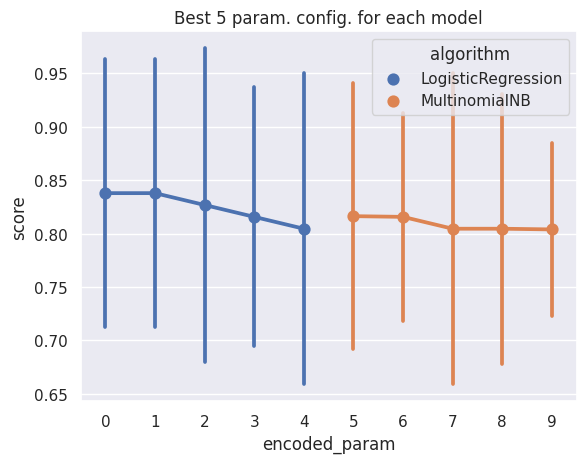

In [ ]:
# Get a list of the unique params, in this way we can encode them to obtain a better plot
params = list(best_fits_tot.params.apply(str).unique())

# Encode the parameters
best_fits_tot["encoded_param"] = best_fits_tot.params.apply(str).apply(lambda x: params.index(x))

# Perform the plot
sns.set()
sns.pointplot(data=best_fits_tot, x="encoded_param", y="score", hue="algorithm", errorbar="sd")\
  .set(title="Best 5 param. config. for each model")
plt.show()

For each plot produced, which combination of hyper-parameters would you select?

[comment]: <> (#SHOW_CELL#)

Looking at our plots we decide to do NOT simply select the models returned from "best_params_" attribute of our Randomized search, but we prefer the parametrizations that have the maximum mean accuracy and the least standard deviation. 
According to these considerations we select parametrization 1 for the Logistic Regression, but for Multinomial Naive Bayes we decided to take parametrization 6 because its mean is close to the best one (the 5-th) and its standard deviation is the shortest one (more precision in accuracy estimation).
We can briefly comment that these two best fits are both characterized by a preprocessing step with stemming of words, stopwords removal and without any normalization of vectors!


### 1.8
For each of the optimizations, obtain a classifier using the parameters we selected in step 1.6.

In [ ]:
# We choose params 0 for the Logistic and 6 for Multinomial Naive Bayes
parameters = {}
# best logistic model
parameters['LogisticRegression'] = best_fits_tot[best_fits_tot.params.apply(str) == params[0]].params.iloc[0]
# best mnb model
parameters['MultinomialNB'] = best_fits_tot[best_fits_tot.params.apply(str) == params[6]].params.iloc[0]

models = {}
for algo in tqdm(search):
  # Vectorizer
  vectorizer = TfidfVectorizer(lowercase=False)
  # Classifier
  clf = classifiers[algo]

  # Pipeline
  pipeline = Pipeline(
      [('vect', vectorizer),
       ('clf', clf)])
  
  # Set the parameters to the pipeline
  pipeline.set_params(**parameters[algo])

  # We train on the training set
  pipeline.fit(train_x, train_y)

  # We save the model in our dictionary
  models[algo] = pipeline

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Apply the classifier(s) to obtain the confusion matrix on the test data and print it out.

[comment]: <> (#SHOW_CELL#)

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        30
           1       0.94      0.96      0.95        46

    accuracy                           0.93        76
   macro avg       0.93      0.93      0.93        76
weighted avg       0.93      0.93      0.93        76



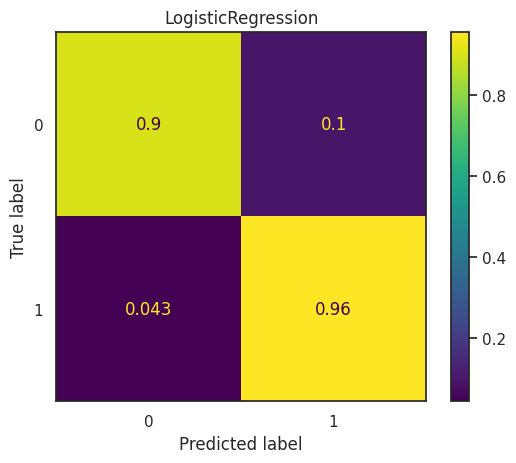



Classification Report for MultinomialNB:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91        30
           1       0.92      0.98      0.95        46

    accuracy                           0.93        76
   macro avg       0.94      0.92      0.93        76
weighted avg       0.94      0.93      0.93        76



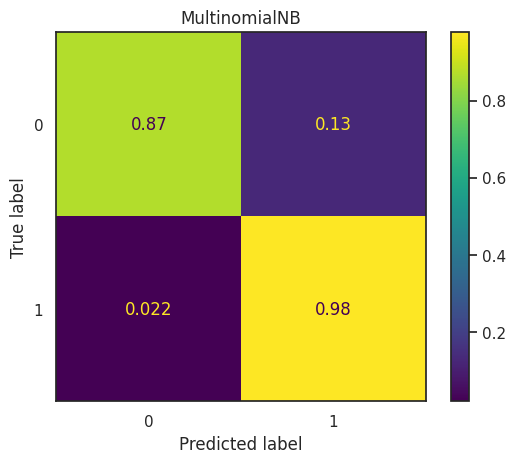

In [ ]:
sns.set_style(style='white')
for algo in models:
  predictions = models[algo].predict(test_x)
  print(f"Classification Report for {algo}:")
  print(classification_report(test_y, predictions, labels=[0, 1]))
  cf=confusion_matrix(test_y, predictions, labels=[0, 1], normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=[0, 1])
  disp.plot()
  disp.ax_.set_title(algo)
  plt.show()
  print()
  print()

### 1.9
We have a training set containing N documents. There are $M_1$ unique terms within the dataset.

The test dataset will have $M_2$ unique terms within it. However, we know that only a small amount of these will be in common with the training dataset.

What precautions could we use to preprocess the data?

What could we change at test time and which of the classification algorithms seen in class would best suit the change?

One approach to the problem might be to preprocess the data (for both the training and test set) by removing the stopwords and/or using a stemmer or a lemmer, so that words with the same root or lemma are mapped into the same term.

Additional preprocessing methods could involve decomposing compound terms and terms divided by symbols and apostrophes to pursue differentiated vectorization for each of the words involved.

At test time, however for some classifiers, it is possible to correct this problem by introducing corrective terms into the formulas or embeddings. 

An example of such corrective terms are the Laplace smoothing factors to be introduced when calculating the probability of observing a word given a certain class in the Naive Bayes model, which could then be a good classifier for our purposes.

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>